In [ ]:
#=============================================
#                                              Adam
#-------------------------------------------------------------------------------
# The problem of dimensionality is addressed by conveying 
# information about the previous gradient while performing 
# exponential decay.
#=============================================

In [ ]:
# PyTorch is 0.4.1.
# torchvision is 0.2.1
# This program uses the above versions.
# If necessary, you can install it by using the following command.

# pip install torch==0.4.1
# pip install torchvision==0.2.1

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

# CIFAR-10 training data
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                                                                train=True,
                                                                                transform=transforms.ToTensor(),
                                                                                download=True)

# CIFAR-10 test data
test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                                                                train=False,
                                                                                transform=transforms.ToTensor(),
                                                                                download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# To display training data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                                          batch_size=64,
                                                                          shuffle=True,
                                                                          num_workers=2)

# To display test data
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                                          batch_size=64, 
                                                                          shuffle=False,
                                                                          num_workers=2)

In [4]:
image, label = train_dataset[0]

# Pixel size of the image
print(image.size())

torch.Size([3, 32, 32])


In [5]:
# Image display functions
def ShowCifer(trainloader, classes):
    Height = 8
    Width = 8
    fig = plt.figure(figsize=(Height, Width))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.4, wspace=0.4)
    
    for i, (images, labels) in enumerate(trainloader, 0):
        for k in range(0, images.size()[0]):
            
            numpy_array = images[k].numpy().transpose((1, 2, 0))
            plt.subplot(Height, Width, k+1)
            plt.imshow(numpy_array)
            
            plt.title("{}".format(classes[labels[k]]), fontsize=12, color="gray")
            plt.axis('off')
        break
        
    plt.show()        

In [6]:
# CIFAR-10 label
cifar10_labels = np.array(["Airplane",
                                              "Automobile",
                                              "Bird",
                                              "Cat",
                                              "Deer",
                                              "Dog",
                                              "Frog",
                                              "Horse",
                                              "Ship",
                                              "Truck"])

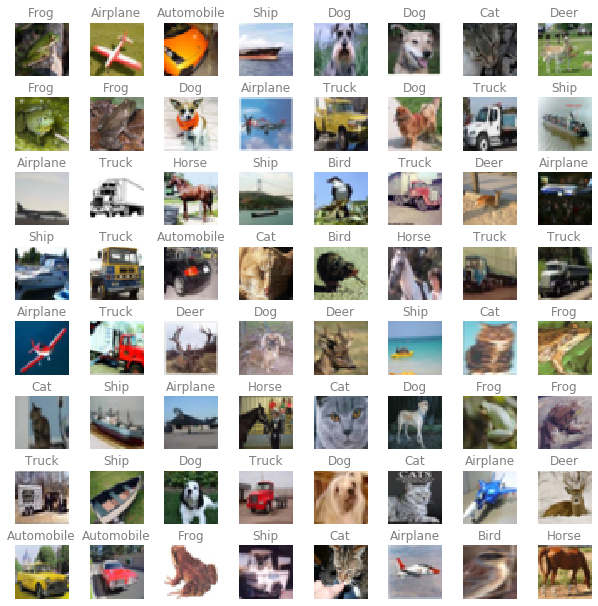

In [7]:
# View training data
ShowCifer(train_loader, cifar10_labels)

In [8]:
num_classes = 10

# Neural network model
class Model(nn.Module):
    
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.features = nn.Sequential(  nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
                                                             nn.ReLU(inplace=True),
                                                             nn.MaxPool2d(kernel_size=2, stride=2),
                                                             nn.Conv2d(64, 192, kernel_size=5, padding=2),
                                                             nn.ReLU(inplace=True),
                                                             nn.MaxPool2d(kernel_size=2, stride=2),
                                                             nn.Dropout(),                               
                                                             nn.Conv2d(192, 256, kernel_size=3, padding=1),
                                                             nn.ReLU(inplace=True),
                                                             nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                                             nn.ReLU(inplace=True),
                                                             nn.MaxPool2d(kernel_size=2, stride=2),
                                                             nn.Dropout(),
                                                           )
        self.classifier = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Model(num_classes).to(device)

#=============================================
# Optimization Algorithm : Adam
#=============================================
optimizer = optim.Adam(net.parameters(), 
                                           lr=0.001,
                                          betas=(0.9, 0.999),
                                          eps=1e-08,
                                          weight_decay=0,
                                          amsgrad=False)
# Loss Function : Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Show Model
net

Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.5)
    (7): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.5)
  )
  (classifier): Linear(in_features=256, out_features=10, bias=True)
)

In [10]:
# Epochs: 20 times
num_epochs = 20

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

# Learning epochs
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    net.train()    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()
        
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    net.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
            
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print('Epoch [{}/{}], loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
              .format(epoch+1,
                             num_epochs,
                             i+1,
                             loss = avg_train_loss,
                             val_loss = avg_val_loss,
                             val_acc = avg_val_acc))
    
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/20], loss: 0.0285, val_loss: 0.0243, val_acc: 0.4252
Epoch [2/20], loss: 0.0244, val_loss: 0.0226, val_acc: 0.4802
Epoch [3/20], loss: 0.0228, val_loss: 0.0220, val_acc: 0.4979
Epoch [4/20], loss: 0.0218, val_loss: 0.0206, val_acc: 0.5316
Epoch [5/20], loss: 0.0209, val_loss: 0.0201, val_acc: 0.5385
Epoch [6/20], loss: 0.0202, val_loss: 0.0194, val_acc: 0.5583
Epoch [7/20], loss: 0.0196, val_loss: 0.0196, val_acc: 0.5624
Epoch [8/20], loss: 0.0190, val_loss: 0.0188, val_acc: 0.5714
Epoch [9/20], loss: 0.0185, val_loss: 0.0186, val_acc: 0.5772
Epoch [10/20], loss: 0.0181, val_loss: 0.0194, val_acc: 0.5575
Epoch [11/20], loss: 0.0176, val_loss: 0.0183, val_acc: 0.5846
Epoch [12/20], loss: 0.0172, val_loss: 0.0183, val_acc: 0.5860
Epoch [13/20], loss: 0.0169, val_loss: 0.0189, val_acc: 0.5717
Epoch [14/20], loss: 0.0167, val_loss: 0.0179, val_acc: 0.5939
Epoch [15/20], loss: 0.0162, val_loss: 0.0180, val_acc: 0.5964
Epoch [16/20], loss: 0.0161, val_loss: 0.0179, val_acc: 0.5980
E

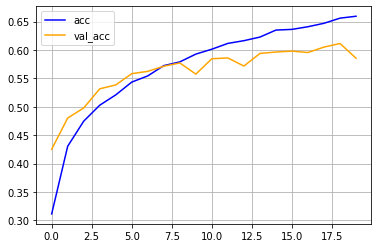

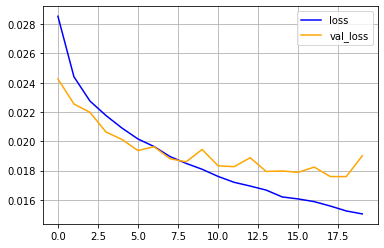

In [11]:
# Display the accuracy graph
plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='acc')
plt.plot(range(num_epochs), val_acc_list, color='orange', linestyle='-', label='val_acc')
plt.legend()
plt.grid()

# Display the loss graph
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='loss')
plt.plot(range(num_epochs), val_loss_list, color='orange', linestyle='-', label='val_loss')
plt.legend()
plt.grid()

In [ ]:
# After 20 repetitions, the accuracy was about 58 to 61%.